In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [182]:
data = pickle.load(open('./benchmark_examples/data/pend_swingup/reward_data.pkl', 'rb'))
data2 = pickle.load(open('./examples/data/pend_swingup/reward_data3.pkl', 'rb'))

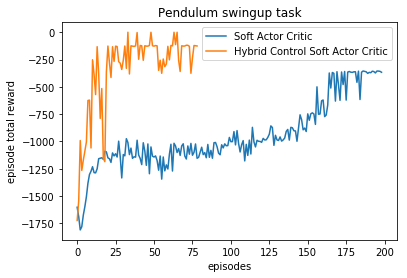

In [183]:
plt.plot(data, label='Soft Actor Critic')
plt.plot(data2, label='Hybrid Control Soft Actor Critic')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Pendulum swingup task')

plt.legend()

plt.savefig('pend_swingup.png')

In [180]:
data = pickle.load(open('./benchmark_examples/data/pend_swingup/reward_data2.pkl', 'rb'))
data2 = pickle.load(open('./examples/data/pend_swingup/reward_data3.pkl', 'rb'))

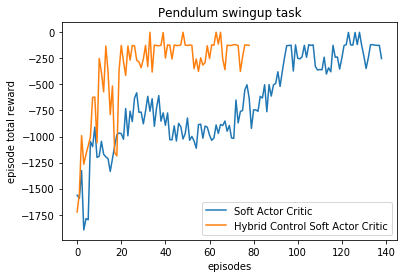

In [181]:
plt.plot(data, label='Soft Actor Critic')
plt.plot(data2, label='Hybrid Control Soft Actor Critic')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Pendulum swingup task')

plt.legend()

plt.savefig('pend_swingup.png')

In [83]:
data2 = [
    pickle.load(open('./benchmark_examples/data/lunar_lander/reward_data2.pkl', 'rb'))[:80],
    pickle.load(open('./benchmark_examples/data/lunar_lander/reward_data.pkl', 'rb'))[:80],    
]


In [84]:
data = [
    pickle.load(open('./examples/data/lunar_lander/reward_data2.pkl', 'rb'))[:80],
    pickle.load(open('./examples/data/lunar_lander/reward_data.pkl', 'rb'))[:80],    
]

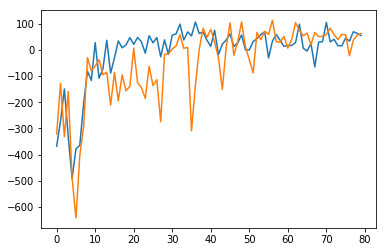

In [85]:
plt.plot(np.mean(data, axis=0))
plt.plot(np.mean(data2, axis=0))

In [473]:
data = pickle.load(open('./benchmark_examples/data/lunar_lander/reward_data4.pkl', 'rb'))
data2 = pickle.load(open('./examples/data/lunar_lander/reward_data4.pkl', 'rb'))

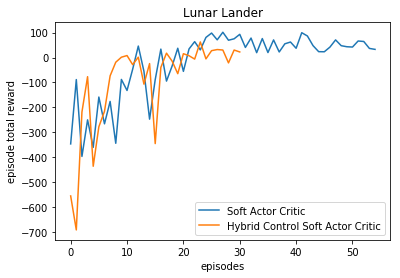

In [474]:
plt.plot(data, label='Soft Actor Critic')
plt.plot(data2, label='Hybrid Control Soft Actor Critic')
plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()

plt.savefig('lunar_lander.png')